### RNAPuzzle test

In [1]:
import os

os.chdir("/home/adamczykb/rnaquanet/src")

In [2]:
import torch
import torch.nn as nn
from rnaquanet.dataset.RNAQuANetDataset import RNAQuANetDataset
from rnaquanet.dataset.RNAQuANetDataset import RNAQuANetDatasetSubset

from torch_geometric import nn as gnn
import lightning as L
from torch_geometric.loader import DataLoader
from numpy import inf


In [3]:
class RNAQuANet(L.LightningModule):
    def __init__(self, number_of_node_features: int):
        super().__init__()
        self.save_hyperparameters()
        self.norm1 = gnn.BatchNorm(number_of_node_features)

        self.GATconv1 = gnn.GATv2Conv(
            number_of_node_features, number_of_node_features, heads=4, edge_dim=35
        )

        self.GATconv2 = gnn.GATv2Conv(
            number_of_node_features * 4, number_of_node_features, heads=4, edge_dim=35
        )
        self.GATconv3 = gnn.GATv2Conv(
            number_of_node_features * 4, number_of_node_features, heads=4, edge_dim=35
        )

        self.GCN2Conv1 = gnn.GeneralConv(
            number_of_node_features * 4, number_of_node_features , in_edge_channels=35
        )
       
        self.fc1 = nn.Linear(number_of_node_features, number_of_node_features)
        self.fc3 = nn.Linear(number_of_node_features, 1)
        self.dropout = nn.Dropout(0.2)
        self.activation = nn.ReLU()
        self.aggregation = gnn.aggr.SetTransformerAggregation(
            number_of_node_features,dropout=0.2,layer_norm=True
        )

    def forward(self, x, edge_index, edge_attr, batch):

        y = self.norm1(x)
        y = self.GATconv1(y, edge_index, edge_attr)
        y = self.activation(y)
        y = self.dropout(y)
        y = self.GATconv2(y, edge_index, edge_attr)
        y = self.activation(y)
        y = self.dropout(y)
        y = self.GATconv3(y, edge_index, edge_attr)
        y = self.activation(y)
        y = self.dropout(y)
        y = self.GCN2Conv1(y, edge_index, edge_attr)
        y = self.activation(y)
        y = self.dropout(y)

        y = self.aggregation(y, batch)

        y = self.fc1(y)
        y = self.activation(y)
        y = self.dropout(y)


        y = self.fc3(y)

        return self.activation(y)

    def training_step(self, data, batch_idx):
        result = self.forward(data.x, data.edge_index, data.edge_attr, data.batch)

        loss = (torch.abs(result - data.y.unsqueeze(-1))).mean()
        loss_mse = (torch.square(torch.abs(result - data.y.unsqueeze(-1)))).mean()

        self.log("train_loss_mae", loss, batch_size=125)
        self.log("train_loss_mse", loss_mse, batch_size=125)
        return loss

    def validation_step(self, data, batch_idx):
        result = self.forward(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = (torch.abs(result - data.y.unsqueeze(-1))).mean()
        loss_mse = (torch.square(torch.abs(result - data.y.unsqueeze(-1)))).mean()

        self.log("val_loss_mae", loss, batch_size=125)
        self.log("val_loss_mse", loss_mse, batch_size=125)
        return loss_mse

    def backward(self, loss):
        loss.backward()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

In [33]:
dataset_test = RNAQuANetDataset(
    f"/home/adamczykb/rnaquanet/data/06_model_input/rnaquanet_structures/test"
)

In [5]:
dataset_test.print_summary()

RNAQuANetDataset (#graphs=2902):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |     58.3 |    705.3 |
| std        |     34.1 |    477   |
| min        |     13   |     60   |
| quantile25 |     33   |    324   |
| median     |     56   |    616   |
| quantile75 |     76   |    976   |
| max        |    176   |   2620   |
+------------+----------+----------+


In [6]:
model = RNAQuANet(dataset_test[0].x.shape[1])

In [28]:
best_model_path='/home/adamczykb/rnaquanet/checkpoints/RNAQuANet_transformer_dataset__all/696898214243479817/43425cc33d2e4a1fa86f098cc3fd7d6d/checkpoints/epoch=35-step=2448.ckpt'
dataset='RNAQuANet'

In [32]:
best_model_path='/home/adamczykb/rnaquanet/checkpoints/RNAQuANet_transformer_ares_dataset__all/306037256498709437/ea35e4e61ff147fcbdb2c0da91520616/checkpoints/epoch=29-step=1680.ckpt'
dataset='ARES'

In [34]:
import mlflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

val_model = RNAQuANet.load_from_checkpoint(
    best_model_path,
    number_of_node_features=dataset_test[0].x.shape[1],strict=False
)
val_model=val_model.eval()
res = []
for n,i in enumerate(dataset_test):
    res.append(
        [
            i.x.shape[0],
            float(val_model(i.x.cuda(), i.edge_index.cuda(), i.edge_attr.cuda(), torch.zeros(i.x.shape[0],dtype=torch.int64).cuda()).detach().cpu().numpy()
            ),
            dataset_test.structures[n].split('.')[0],
            i.y.numpy()[0]
        ]
    )
df = pd.DataFrame(np.array(res), columns=["length", "error",'name','true_rmsd'])
# fig, ax = plt.subplots(figsize=(25, 10))

# df.boxplot(column="error", by="length", ax=ax)
# ax.set_xlabel("structure length")
# ax.set_ylabel("error")
# ax.set_title("Error distribution by sequence length on validation set")
# plt.tight_layout()

# plt.show()

# fig, ax = plt.subplots(figsize=(25, 10))
# df.groupby("length").mean().plot(kind="bar", ax=ax)
# ax.set_xlabel("structure length")
# ax.set_ylabel("mean error")
# ax.set_title("Mean error by sequence length on validation set")
# plt.show()

# fig, ax = plt.subplots(figsize=(25, 10))
# df.groupby("length").count().plot(kind="bar", ax=ax)

# ax.set_xlabel("structure length")
# ax.set_ylabel("cardinality")
# ax.set_title("Cardinality by sequence length on validation set")
# plt.show()



/tmp/ipykernel_4626/183482785.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  float(val_model(i.x.cuda(), i.edge_index.cuda(), i.edge_attr.cuda(), torch.zeros(i.x.shape[0],dtype=torch.int64).cuda()).detach().cpu().numpy()


In [37]:
df

,length,error,name,true_rmsd
0,119,11.006729125976562,8AZW_1_C_3,13.559
1,105,10.82103157043457,4WFL_1_A_6,38.309
2,13,3.2087881565093994,1N35_1_CB_5,6.73
3,68,11.19047737121582,6GSL_1_1L_16,20.016
4,37,11.062030792236328,6TY9_1_TN_3,10.448
...,...,...,...,...
2897,108,10.9396390914917,4QLM_1_A_14,26.846
2898,35,10.243715286254883,6BHJ_1_E_16,6.388
2899,120,10.918901443481445,8CVM_1_b_29,23.191
2900,76,11.08353042602539,6WOO_1_3_17,5.024


In [38]:
a=pd.read_csv('/home/adamczykb/rnaquanet/data/01_raw/rnaquanet_structures/output/output.csv')
a['id']=a['id'].str.split('.').str[0]

In [41]:
a = a.merge(df, left_on='id', right_on='name')

In [44]:
display(((a['pred'].astype(float)-a['true_rmsd'].astype(float))**2).mean())
display((abs(a['pred'].astype(float)-a['true_rmsd'].astype(float))).mean())

105.53887376538849

7.897793208545831

In [9]:
from pymol import cmd
result = pd.DataFrame(res,columns=["length","error","name"])
original = pd.read_csv('/home/adamczykb/rnaquanet/notebooks/PZ38r.csv')
original['Name']='PZ38_'+original['Lab']+'_'+original['Num'].astype(str)
result=pd.merge(result,original,left_on='name',right_on='Name')
result['diff']=result['error']-result['RMSD']


name = []
rmsd_C5prim = []
rmsd_global = []

for i in list(result['Name']):
    cmd.reinitialize()
    cmd.load(f"/home/adamczykb/rnaquanet/data/01_raw/PZ38/test/{i}.pdb")
    cmd.load(f"/home/adamczykb/rnaquanet/data/01_raw/PZ38/test/PZ38_solution_0.pdb")
    cmd.hide("everything")
    cmd.show("cartoon")
    cmd.color("white")
    rmsd_global.append(cmd.align(f"{i}","PZ38_solution_0",cycles=0)[0])
    # rmsd_C5prim.append(cmd.align(f"/{i}////C5'","/PZ38_solution_0////C5'")[0])
    name.append(i)
result=pd.merge(result,pd.DataFrame(zip(name,rmsd_global,rmsd_C5prim),columns=['Name','true_rmsd_global','true_rmsd_C5prim']),on='Name')
result['true_rmsd_global_diff']=result['error']-result['true_rmsd_global']
result['true_rmsd_C5prim_diff']=result['error']-result['true_rmsd_C5prim']
result=result.sort_values('diff').reset_index(drop=True)
    

In [35]:
display(((df['error'].astype(float)-df['true_rmsd'].astype(float))**2).mean())
display((abs(df['error'].astype(float)-df['true_rmsd'].astype(float))).mean())

85.01281029164029

7.369520936676751

In [24]:
display(((df['error'].astype(float)-df['true_rmsd'].astype(float))**2).mean())
display((abs(df['error'].astype(float)-df['true_rmsd'].astype(float))).mean())

10.786630764006887

2.8393447219209675

In [10]:
result[['Name','error','RMSD','diff','true_rmsd_global','true_rmsd_C5prim','true_rmsd_global_diff','true_rmsd_C5prim_diff']]

,Name,error,RMSD,diff,true_rmsd_global,true_rmsd_C5prim,true_rmsd_global_diff,true_rmsd_C5prim_diff
0,PZ38_Ding_5,9.183729,23.044,-13.860271,9.852570,9.108221,-0.668840,0.075508
1,PZ38_Dfold_5,9.234023,21.296,-12.061977,21.027428,21.834007,-11.793405,-12.599984
2,PZ38_Dfold_2,9.234023,21.296,-12.061977,21.027428,21.834007,-11.793405,-12.599984
3,PZ38_Dfold_3,8.949988,19.824,-10.874012,19.823502,21.004736,-10.873513,-12.054748
4,PZ38_Dfold_1,9.486013,20.279,-10.792987,16.670792,18.040272,-7.184778,-8.554258
...,...,...,...,...,...,...,...,...
69,PZ38_Chen_4,9.518812,8.196,1.322812,7.499064,9.051913,2.019748,0.466899
70,PZ38_Szachniuk_3,11.257517,9.436,1.821517,8.254411,8.551076,3.003106,2.706441
71,PZ38_Chen_9,10.283449,8.239,2.044449,7.742313,8.398361,2.541136,1.885088
72,PZ38_Chen_3,10.238720,7.978,2.260720,7.711173,7.788989,2.527547,2.449731


In [18]:
display(f"MAE: {abs(result['diff']).mean()}")
display(f"MSE: {(result['diff']**2).mean()}")
display(f"MEDIAN: {abs(result['diff']).median()}")

'MAE: 3.5873567428588866'

'MSE: 22.323383320217214'

'MEDIAN: 2.6044692611694336'

In [19]:
display(f"MAE: {abs(result['true_rmsd_global_diff']).mean()}")
display(f"MSE: {(result['true_rmsd_global_diff']**2).mean()}")
display(f"MEDIAN: {abs(result['true_rmsd_global_diff']).median()}")

'MAE: 3.094382769352681'

'MSE: 16.504310935931947'

'MEDIAN: 2.3737480640411377'

In [20]:
display(f"MAE: {abs(result['true_rmsd_C5prim_diff']).mean()}")
display(f"MSE: {(result['true_rmsd_C5prim_diff']**2).mean()}")
display(f"MEDIAN: {abs(result['true_rmsd_C5prim_diff']).median()}")

'MAE: 4.04645012520455'

'MSE: 25.246581979936956'

'MEDIAN: 3.4779953956604004'

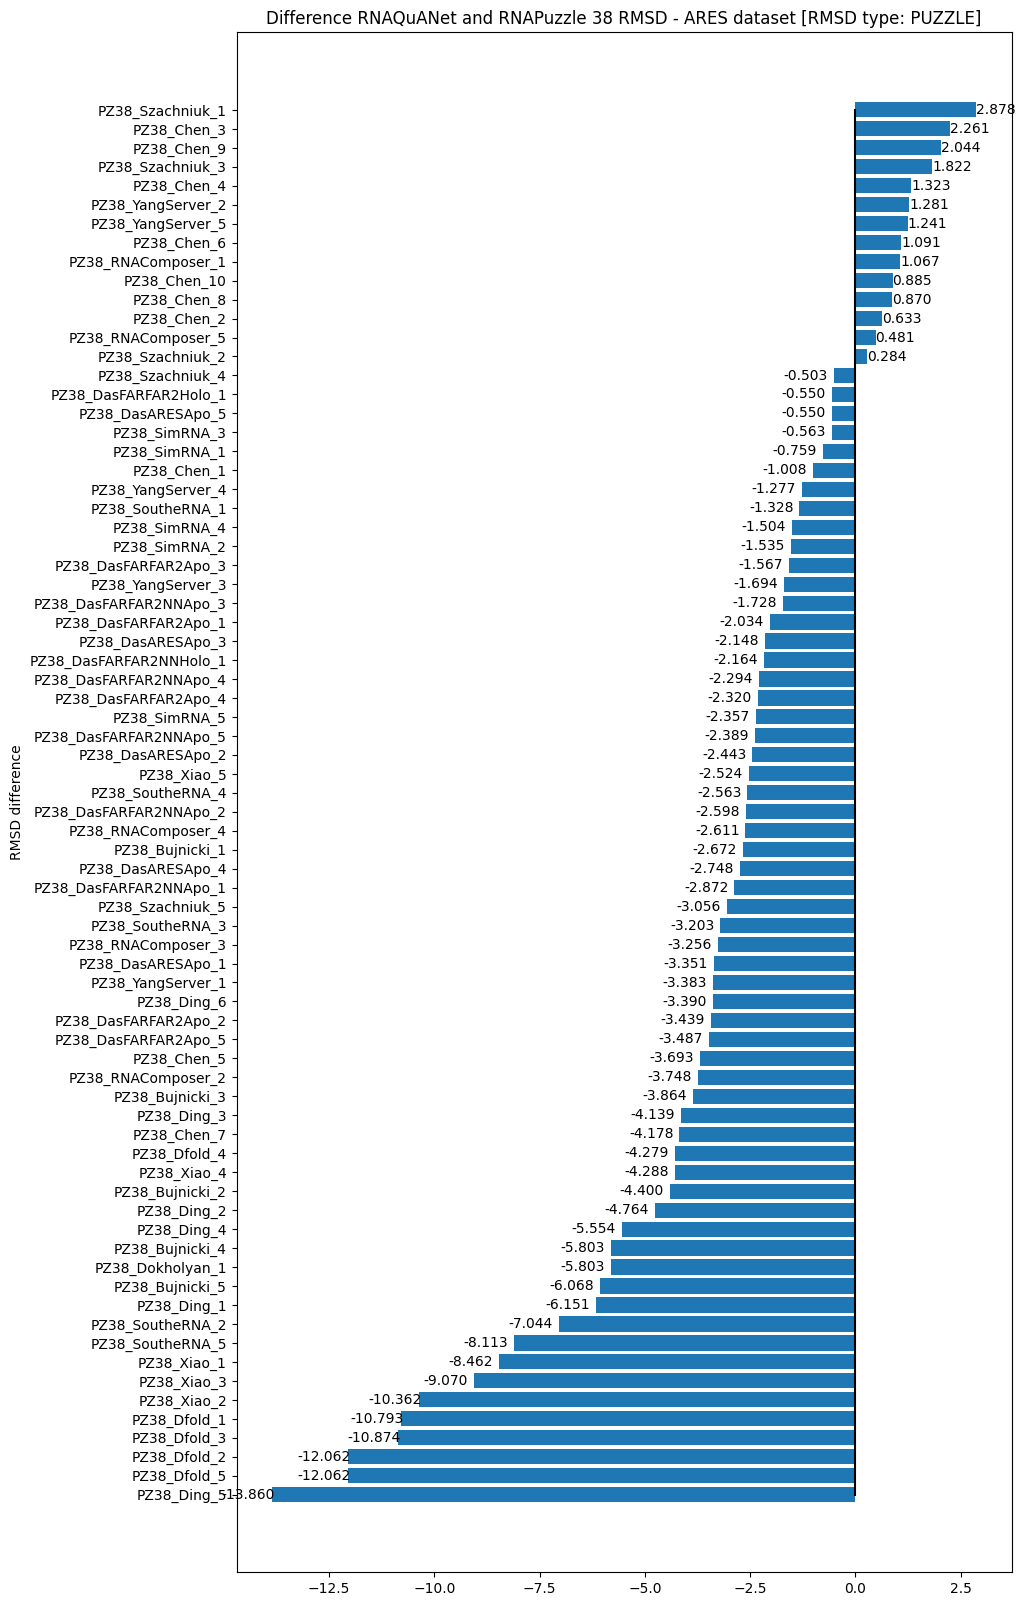

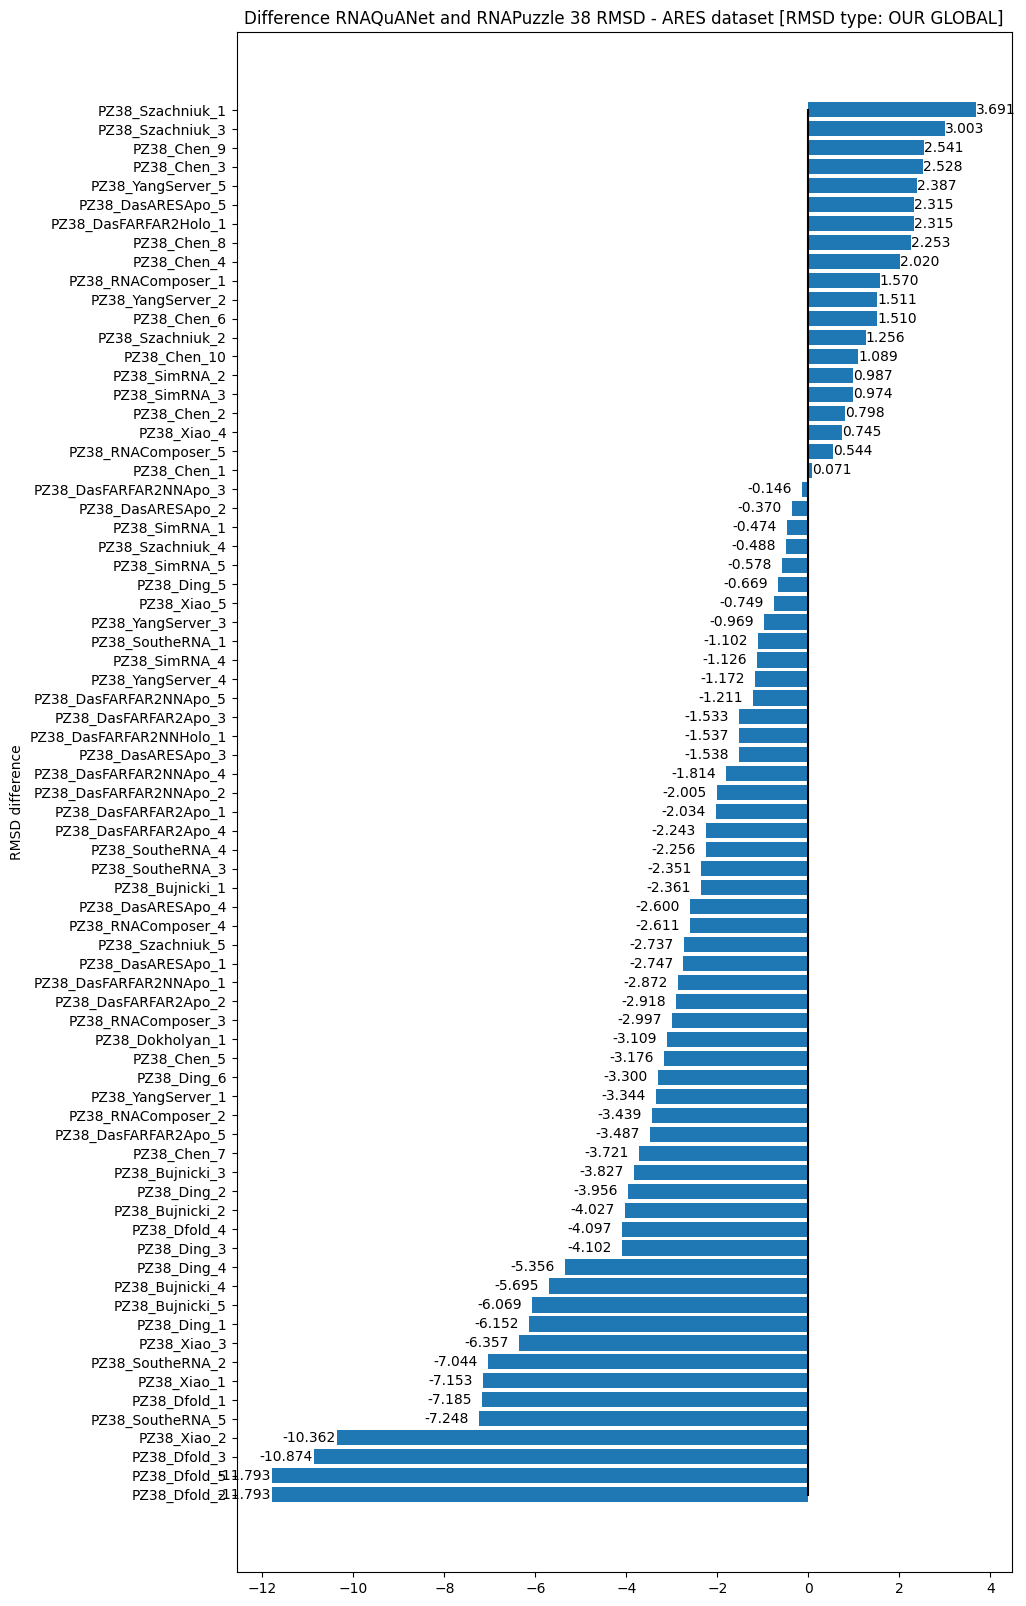

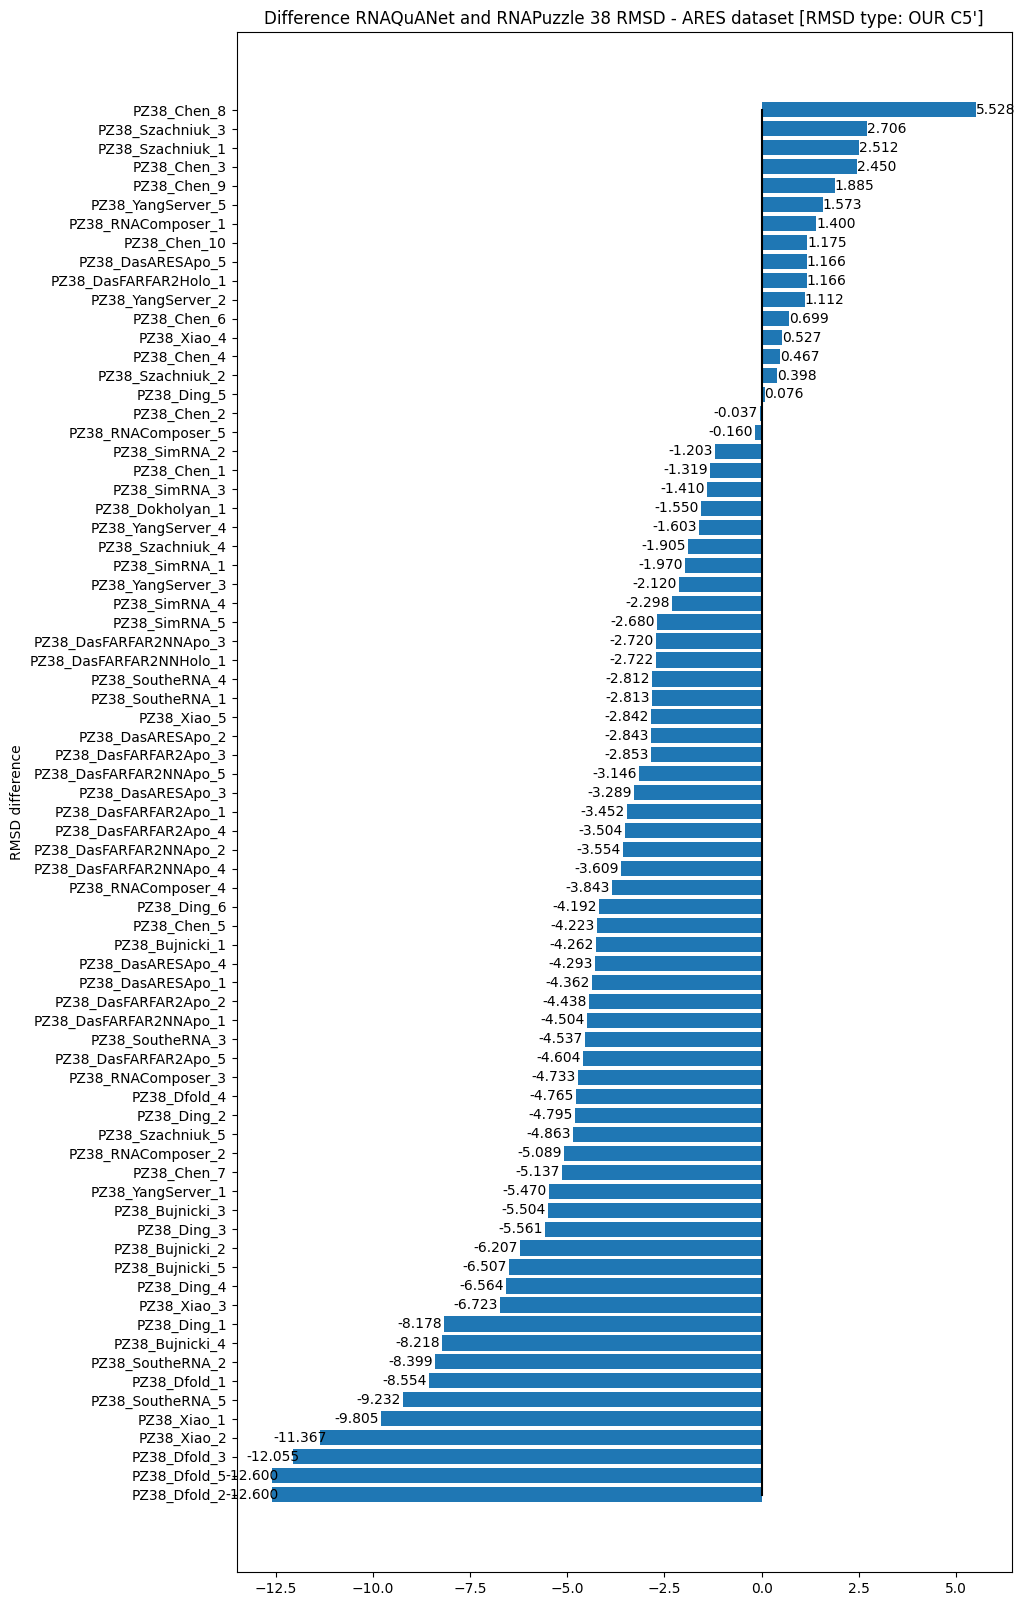

In [14]:
import matplotlib.pyplot as plt
trained_on = dataset
for by in ['diff','true_rmsd_global_diff','true_rmsd_C5prim_diff']:
# Sample data
    match by:
        case 'diff':
            by_name='PUZZLE'
        case 'true_rmsd_global_diff':
            by_name='OUR GLOBAL'
        case 'true_rmsd_C5prim_diff':
            by_name='OUR C5\''
    
    result=result.sort_values(by=by).reset_index(drop=True)
    # Create a bar plot
    fig, ax = plt.subplots(figsize=(10, 20))

    # Plot bars
    bars = ax.barh(result['Name'], result[by], capsize=5)

    # Rotate the y-axis data series by 90 degrees

    # Set labels
    # plt.xticks(rotation=90)
    ax.set_ylabel('RMSD difference')
    ax.plot( [0]*len(result['Name']),result['Name'], linestyle='solid', linewidth=1.5, color='black')
    ax.set_title(f'Difference RNAQuANet and RNAPuzzle 38 RMSD - {trained_on} dataset [RMSD type: {by_name}]')
    for i in range(len(result['Name'])):
        if result[by][i]<0:
            ax.text(result[by][i]-1.2,i,'{p:.3f}'.format(p=result[by][i]), verticalalignment='center')
        else:
            ax.text(result[by][i],i,'{p:.3f}'.format(p=result[by][i]), verticalalignment='center')
    # Show plot
    plt.savefig(f'/home/adamczykb/rnaquanet/notebooks/puzzle38_compare/{trained_on}_{by}.svg')
    plt.show()

In [114]:
import scipy.stats as stats

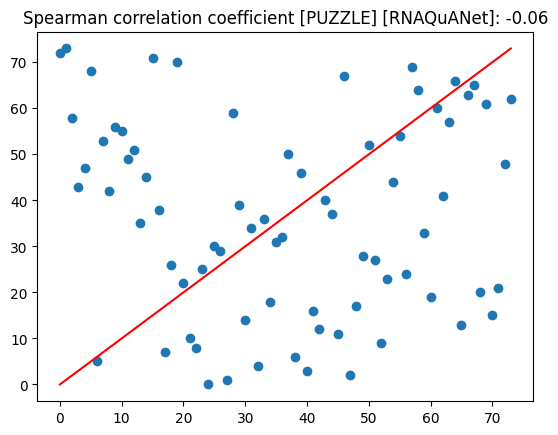

In [126]:
rmsd_sorted = result.sort_values(by='RMSD').index
error_sorted = result.sort_values(by='error').index
result['spearman_distance_puzzle']=abs(rmsd_sorted-error_sorted)

plt.scatter(rmsd_sorted, error_sorted)
plt.plot(np.sort(rmsd_sorted), np.sort(error_sorted), color='red')
plt.title("Spearman correlation coefficient [PUZZLE] [{:s}]: {:.2f}".format(dataset,stats.spearmanr(rmsd_sorted,error_sorted).statistic))
plt.savefig(f'/home/adamczykb/rnaquanet/notebooks/puzzle38_compare/{dataset}_PUZZLE_spearman.svg')

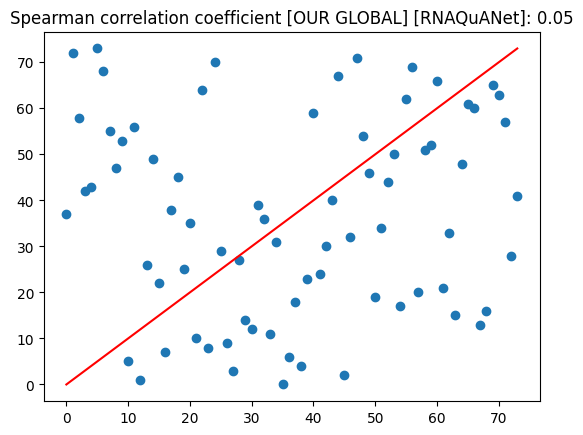

In [125]:
rmsd_sorted = result.sort_values(by='true_rmsd_global').index
error_sorted = result.sort_values(by='error').index
result['spearman_distance_global']=abs(rmsd_sorted-error_sorted)
plt.scatter(rmsd_sorted, error_sorted)
plt.plot(np.sort(rmsd_sorted), np.sort(error_sorted), color='red')
plt.title("Spearman correlation coefficient [OUR GLOBAL] [{:s}]: {:.2f}".format(dataset,stats.spearmanr(rmsd_sorted,error_sorted).statistic))
plt.savefig(f'/home/adamczykb/rnaquanet/notebooks/puzzle38_compare/{dataset}_GLOBAL_spearman.svg')

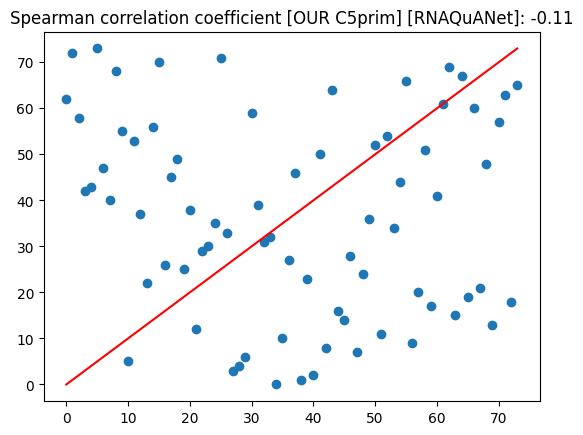

In [124]:
rmsd_sorted = result.sort_values(by='true_rmsd_C5prim').index
error_sorted = result.sort_values(by='error').index
result['spearman_distance_C5prim']=abs(rmsd_sorted-error_sorted)
plt.scatter(rmsd_sorted, error_sorted)
plt.plot(np.sort(rmsd_sorted), np.sort(error_sorted), color='red')
plt.title("Spearman correlation coefficient [OUR C5prim] [{:s}]: {:.2f}".format(dataset,stats.spearmanr(rmsd_sorted,error_sorted).statistic))
plt.savefig(f'/home/adamczykb/rnaquanet/notebooks/puzzle38_compare/{dataset}_C5prim_spearman.svg')

In [118]:
result[['Name','error','RMSD','diff','true_rmsd_global','true_rmsd_C5prim','true_rmsd_global_diff','true_rmsd_C5prim_diff','spearman_distance_puzzle','spearman_distance_global','spearman_distance_C5prim']].to_csv(f'/home/adamczykb/rnaquanet/notebooks/puzzle38_compare/PZ38r_{dataset}.csv',index=False)

In [131]:
result[['Name','error','RMSD','diff','true_rmsd_global','true_rmsd_C5prim','true_rmsd_global_diff','true_rmsd_C5prim_diff','spearman_distance_puzzle','spearman_distance_global','spearman_distance_C5prim']]

,Name,error,RMSD,diff,true_rmsd_global,true_rmsd_C5prim,true_rmsd_global_diff,true_rmsd_C5prim_diff,spearman_distance_puzzle,spearman_distance_global,spearman_distance_C5prim
0,PZ38_Dfold_2,2.549299,21.296,-18.746701,21.027428,21.834007,-18.478128,-19.284708,52,54,56
1,PZ38_Dfold_5,2.549300,21.296,-18.746700,21.027428,21.834007,-18.478128,-19.284708,50,40,46
2,PZ38_Xiao_2,2.400689,19.748,-17.347311,19.748251,20.753014,-17.347562,-18.352324,55,48,48
3,PZ38_Dfold_3,3.988557,19.824,-15.835443,19.823502,21.004736,-15.834944,-17.016179,2,4,8
4,PZ38_SoutheRNA_5,2.433304,17.980,-15.546696,17.114695,19.099081,-14.681391,-16.665777,6,14,13
...,...,...,...,...,...,...,...,...,...,...,...
69,PZ38_Chen_3,2.062412,7.978,-5.915588,7.711173,7.788989,-5.648761,-5.726577,63,62,60
70,PZ38_Chen_9,2.779423,8.239,-5.459577,7.742313,8.398361,-4.962891,-5.618938,72,68,68
71,PZ38_Szachniuk_4,7.574487,11.764,-4.189513,11.748793,13.165589,-4.174305,-5.591102,56,56,56
72,PZ38_Szachniuk_3,5.669457,9.436,-3.766543,8.254411,8.551076,-2.584953,-2.881618,72,71,71
